Files already downloaded and verified
Files already downloaded and verified
Epoch: 1 	Training Loss: 1.999933 	Validation Loss: 1.772968 	Training Accuracy: 24.43% 	Validation Accuracy: 35.32%
Validation loss decreased (inf --> 8864.839133). Saving model ...
Epoch: 2 	Training Loss: 1.508506 	Validation Loss: 1.313813 	Training Accuracy: 44.64% 	Validation Accuracy: 51.94%
Validation loss decreased (8864.839133 --> 6569.065117). Saving model ...
Epoch: 3 	Training Loss: 1.263343 	Validation Loss: 1.147337 	Training Accuracy: 54.26% 	Validation Accuracy: 58.86%
Validation loss decreased (6569.065117 --> 5736.685885). Saving model ...
Epoch: 4 	Training Loss: 1.089599 	Validation Loss: 0.995308 	Training Accuracy: 61.32% 	Validation Accuracy: 63.98%
Validation loss decreased (5736.685885 --> 4976.539984). Saving model ...
Epoch: 5 	Training Loss: 0.967586 	Validation Loss: 0.981271 	Training Accuracy: 65.66% 	Validation Accuracy: 64.74%
Validation loss decreased (4976.539984 --> 4906.356

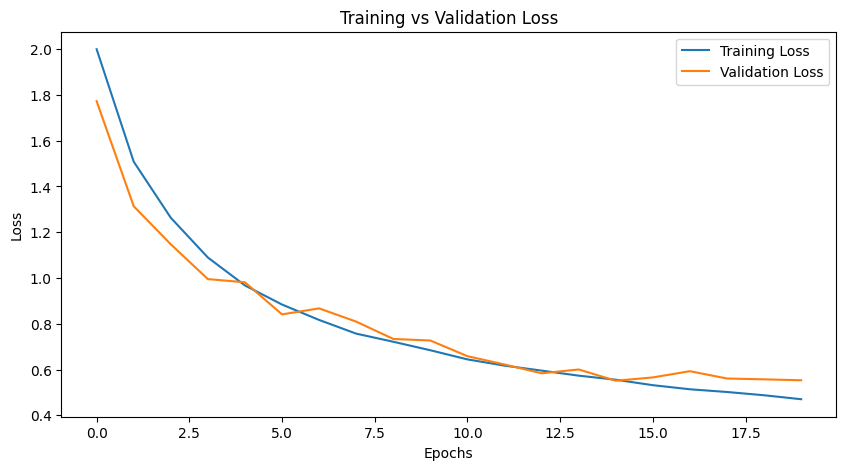

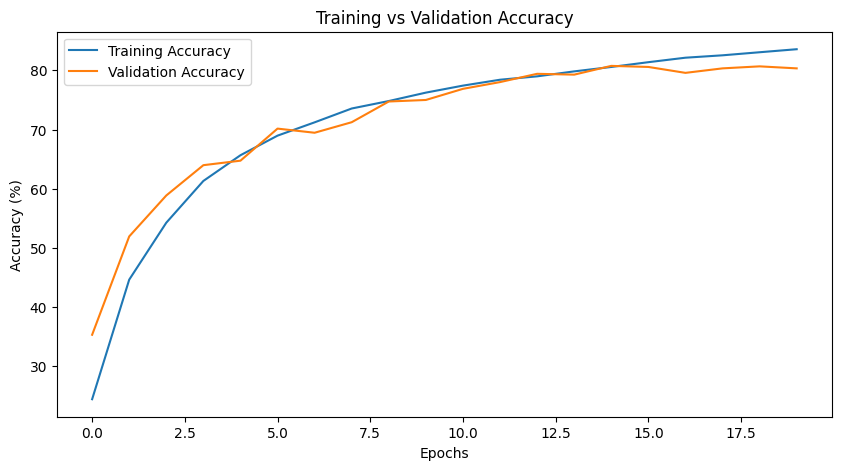

Accuracy of the network on the 10000 test images: 84 %


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import torch.utils.data
import matplotlib.pyplot as plt
import numpy as np

class MiniVGG(nn.Module):
    def __init__(self):
        super(MiniVGG, self).__init__()
        self.features = self._make_layers([64, 64, 'M', 128, 128, 'M', 256, 256, 'M'])
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.ReLU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)

def load_split_train_test(datadir, valid_size=.2):
    normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        normalize,
    ])

    test_transforms = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

    train_data = datasets.CIFAR10(datadir, train=True, download=True, transform=train_transforms)
    test_data = datasets.CIFAR10(datadir, train=False, download=True, transform=test_transforms)
    
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
    valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)

    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=64)
    validloader = torch.utils.data.DataLoader(train_data, sampler=valid_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

    return trainloader, validloader, testloader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = MiniVGG().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
trainloader, validloader, testloader = load_split_train_test('./data', valid_size=0.1)


def train(n_epochs, patience_limit):
    valid_loss_min = np.Inf
    patience = 0  # Counter for the number of epochs without improvement
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        correct = 0
        total = 0
        
        net.train()
        for data, target in trainloader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss / len(trainloader.sampler))
        train_accuracies.append(train_accuracy)
        
        net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in validloader:
                data, target = data.to(device), target.to(device)
                output = net(data)
                loss = criterion(output, target)
                valid_loss += loss.item() * data.size(0)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
                
        valid_accuracy = 100 * correct / total
        valid_losses.append(valid_loss / len(validloader.sampler))
        valid_accuracies.append(valid_accuracy)
        
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTraining Accuracy: {:.2f}% \tValidation Accuracy: {:.2f}%'.format(
            epoch, train_loss / len(trainloader.sampler), valid_loss / len(validloader.sampler),
            train_accuracy, valid_accuracy))
        
        # Check if the validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(net.state_dict(), 'model_cifar.pt')
            valid_loss_min = valid_loss
            patience = 0  # Reset patience since we have an improvement
        else:
            patience += 1  # Increment the patience counter
            print(f'Patience for {patience} epochs.')
            if patience >= patience_limit:
                print('Early stopping triggered.')
                break
    
    return train_losses, valid_losses, train_accuracies, valid_accuracies

# Example usage
patience_limit = 5  # Number of epochs to tolerate no improvement
train_losses, valid_losses, train_accuracies, valid_accuracies = train(50, patience_limit)


# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Test the model with test data
def test():
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

test()